### 导入autoload扩展

In [1]:
%load_ext autoreload
%autoreload 2

### 下载并载入[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)数据集

In [50]:
from main import download_minist
from full_connect_network import FullConnectNet
from solve import Solver
import random

data = download_minist()

hidden_dims = [64, 32, 16]
activation = ['relu']
reg = 0
loss = 'ce'

three_layer_model = FullConnectNet(
    hidden_dims=hidden_dims, 
    types=activation, 
    reg=reg, 
    loss=loss
)

three_layer_net = Solver(
    model=three_layer_model, 
    data=data,
    update_rule='adam',
    lr_decay=0.6,
    print_iter=50
)

three_layer_net.train() 



(Time   0.01 s; Iteration    1 / 12000) loss 10.246722
[Epoch  0 / 10] train accuracy: 0.103767; val accuracy: 0.103900
(Time   0.59 s; Iteration   51 / 12000) loss 1.015250
(Time   0.77 s; Iteration  101 / 12000) loss 0.934132
(Time   0.96 s; Iteration  151 / 12000) loss 0.939601
(Time   1.15 s; Iteration  201 / 12000) loss 0.830337
(Time   1.34 s; Iteration  251 / 12000) loss 0.770656
(Time   1.54 s; Iteration  301 / 12000) loss 0.538532
(Time   1.73 s; Iteration  351 / 12000) loss 0.619958
(Time   1.93 s; Iteration  401 / 12000) loss 0.585623
(Time   2.13 s; Iteration  451 / 12000) loss 0.610563
(Time   2.33 s; Iteration  501 / 12000) loss 0.665201
(Time   2.52 s; Iteration  551 / 12000) loss 0.749116
[Epoch  1 / 10] train accuracy: 0.813800; val accuracy: 0.800000
(Time   3.12 s; Iteration  601 / 12000) loss 0.434288
(Time   3.32 s; Iteration  651 / 12000) loss 0.509530
(Time   3.51 s; Iteration  701 / 12000) loss 0.507454
(Time   3.71 s; Iteration  751 / 12000) loss 0.624543
(Time

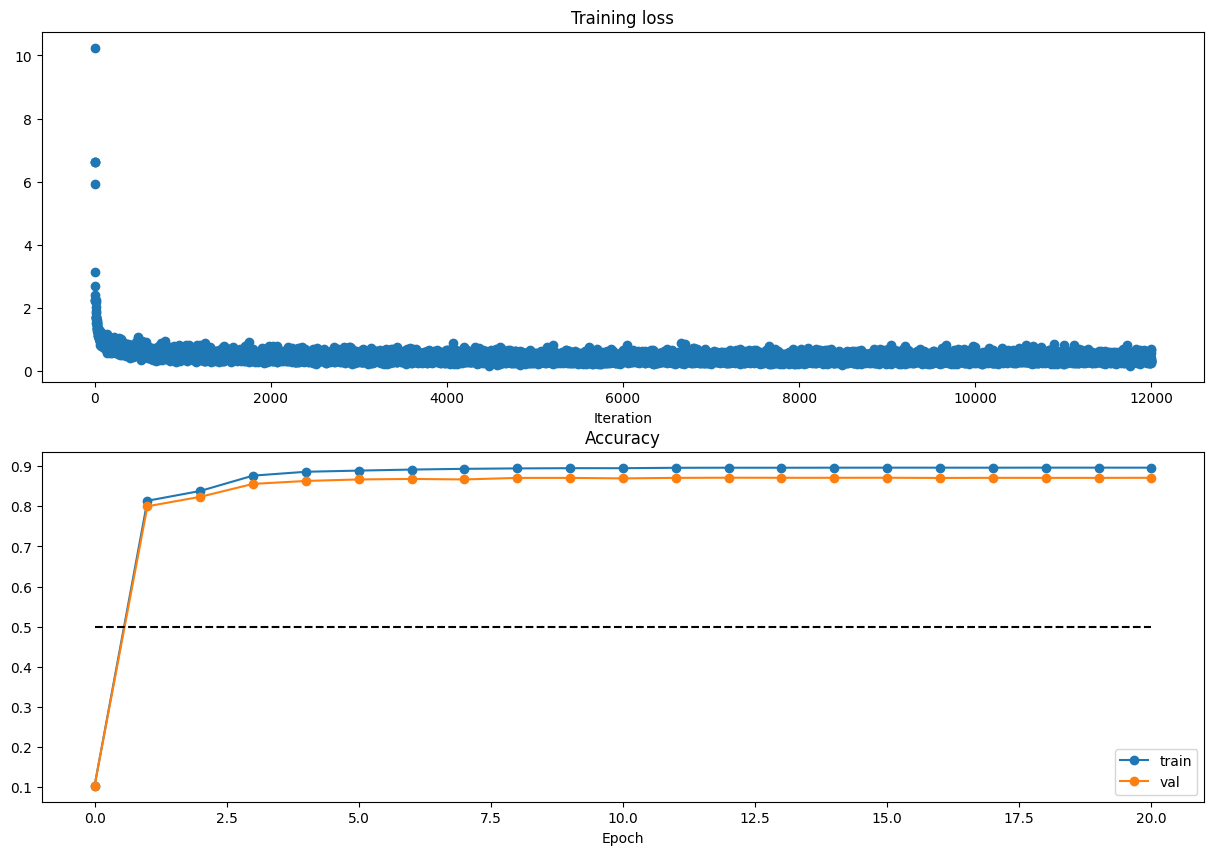

In [51]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(three_layer_net.loss_hist, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(three_layer_net.train_acc_hist, '-o', label='train')
plt.plot(three_layer_net.val_acc_hist, '-o', label='val')
plt.plot([0.5] * len(three_layer_net.val_acc_hist), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 10)
plt.show()